<a href="https://colab.research.google.com/github/lightucha/how-to-opencv/blob/main/opencv_210901.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 패캠 openCV ch11~13 Review
- 이미지와 머신러닝

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print(cv2.__version__)

4.1.2


In [ ]:
gpath = '/content/drive/MyDrive/1.Project/{PATH}/'

### OpenCV 머신러닝

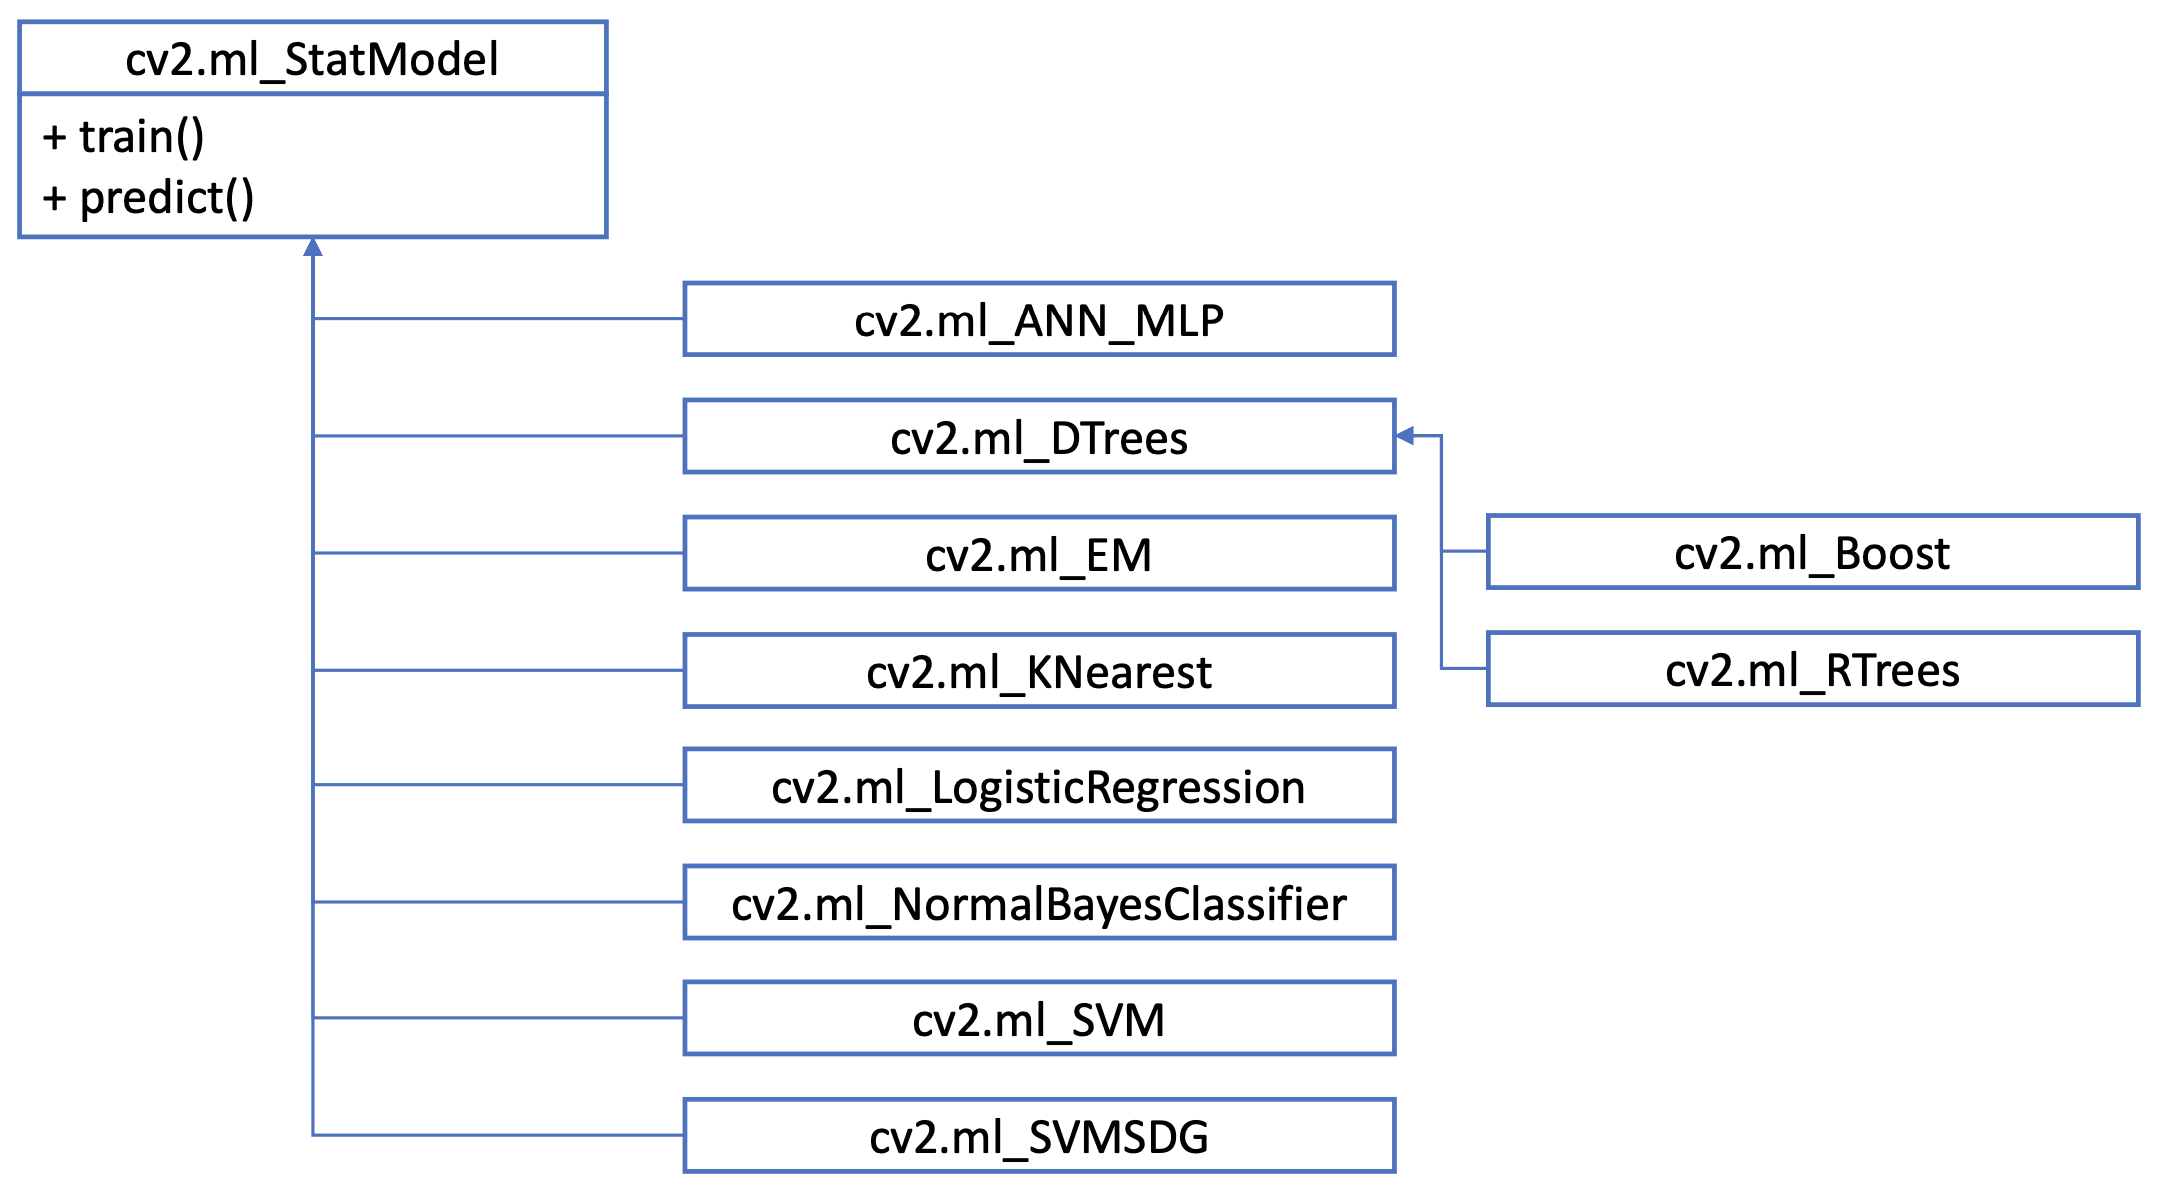

### 머신러닝 알고리즘 객체 생성

<b>cv2.ml.XXX_create()</b>

- _create() 명령어로 객체를 생성

### 머신러닝 알고리즘 학습

<b>cv2.ml_XXX.train(samples, layout, response) -> retval</b>
- samples: dtype=numpy.float32
- retval: 학습 성공 시 True

### 머신러닝 알고리즘 예측

<b>cv2.ml_XXX.predict(samples, results=None, flags=None) -> retval, results</b>
- flags: 기본값은 0. cv2.ml.STAT_MODEL_RAW_OUTPUT 지정 시 클래스 레이블이 아닌 실제 계산 결과 값 출력

### KNN 필기체 숫자 인식
- 만약 정해진 폰트로 인쇄된 숫자라면 <_템플릿 매칭_>으로도 가능

<b>1. cv2.ml.KNearest_create() -> retval</b>

<b>2. cv2.ml_KNearest.train(samples, layout, responses) -> retval</b>
- samples: 학습 데이터 행렬. numpy.ndarray. shape=(N, d), dtype=numpy.float32.
- layout: 학습 데이터 배치 방법.
  cv2.ROW_SAMPLE : 하나의 데이터가 한 행으로 구성됨
  cv2.COL_SAMPLE : 하나의 데이터가 한 열로 구성됨
- responses: 각 학습 데이터에 대응되는 응답(레이블) 행렬. numpy.ndarray. shape=(N, 1), dtype=numpy.int32 또는 numpy.float32.

<b>3. cv.ml_KNearest.findNearest(samples, k, results=None, neighborResponses=None, dist=None , flags=None) -> retval, results, neighborResponses, dist</b>
- k: 사용할 최근접 이웃 개수

KNN 방법은 단순히 픽셀 값만 이용
- 픽셀값 자체를 이용하는 것이 제일 간단하고 가장 간단하게 필기체를 구분

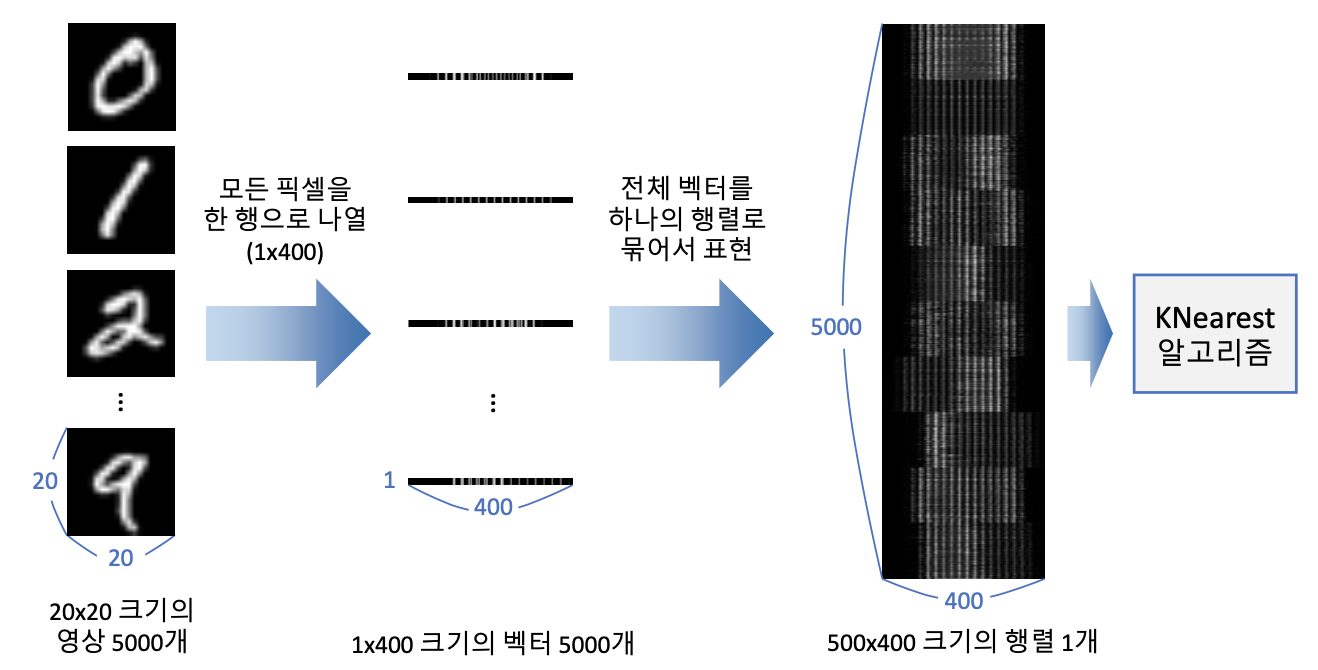

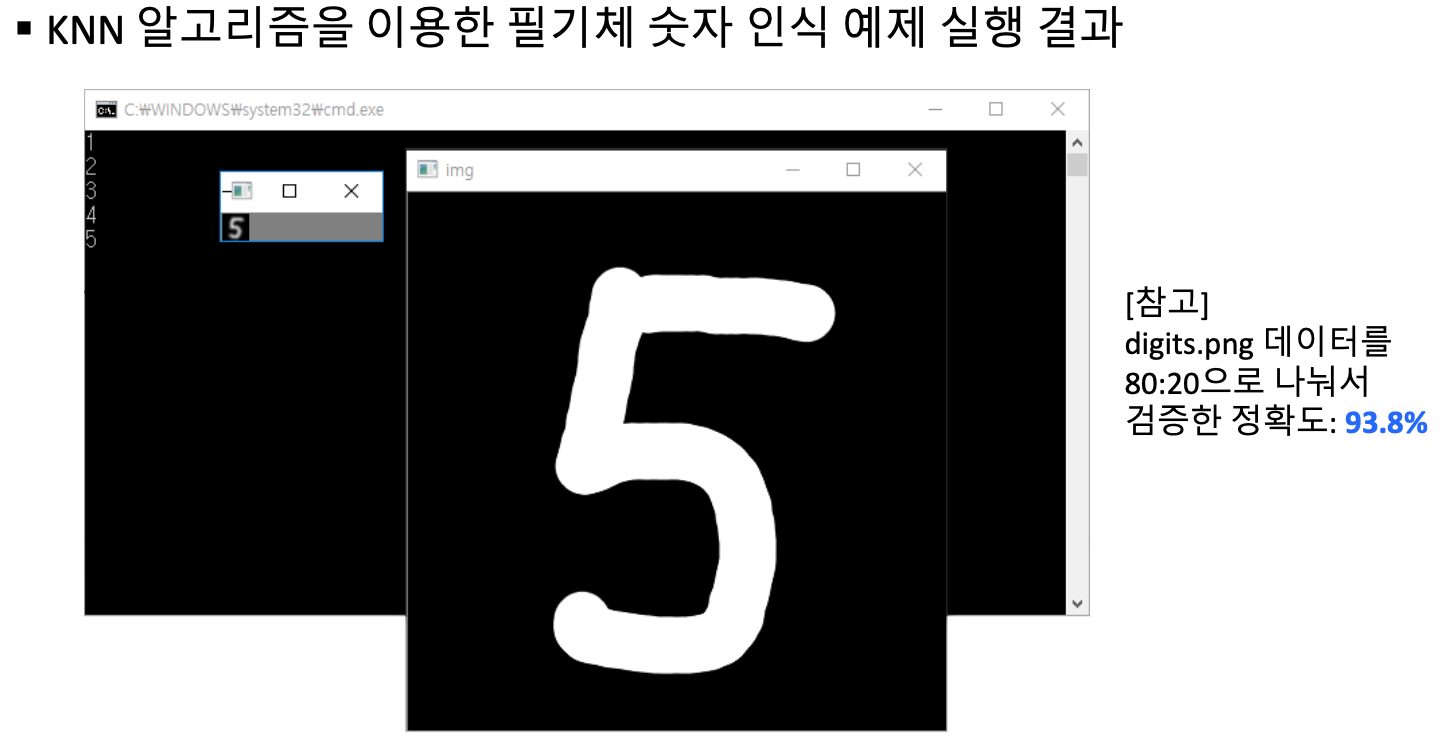

### HOG & SVM 필기체 숫자 인식
HOG 알고리즘으로 추출한 특징 벡터를 이용하여 SVM을 학습시키는 것이 정확도가 더 뛰어남

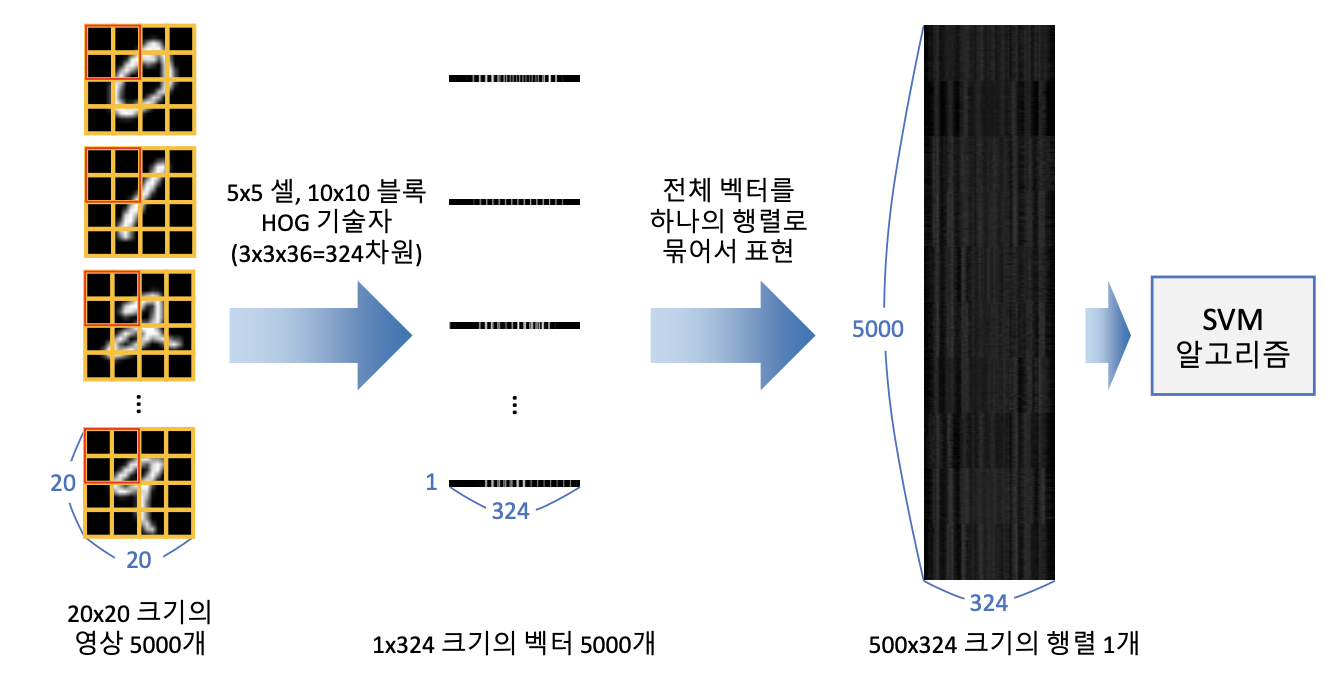

In [ ]:
#학습 데이터&레이블 행렬 생성
digits = cv2.imread(gpath+'ch11/digits.png', cv2.IMREAD_GRAYSCALE)

h, w = digits.shape[:2]
# HODDescriptor 객체 생성
hog = cv2.HOGDescriptor((20, 20), (10, 10), (5, 5), (5, 5), 9)

cells = [np.hsplit(row, w//20) for row in np.vsplit(digits, h//20)] 
cells = np.array(cells)
cells = cells.reshape(-1, 20, 20) # shape=(5000, 20, 20)

# HOG 기술자 계산
# desc는 (324, 1) ndarray 5000개를 가진 리스트.
desc = []
for img in cells:
  desc.append(hog.compute(img))

train_desc = np.array(desc).squeeze().astype(np.float32)
train_labels = np.repeat(np.arange(10), len(train_desc)/10)
# train_desc: shape=(5000, 324), dtype=float32 
# train_labels: shape=(5000, ), dtype=int32
  

In [ ]:
# SVM 학습
svm = cv2.ml.SVM_create() 
svm.setType(cv2.ml.SVM_C_SVC) 
svm.setKernel(cv2.ml.SVM_RBF)
svm.setC(2.5)
svm.setGamma(0.50625)
svm.train(train_desc, cv2.ml.ROW_SAMPLE, train_labels)

True

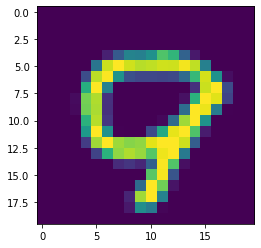

9


In [ ]:
#사용자 입력 영상에 대해 예측 
test_image = cv2.resize(img, (20, 20), interpolation=cv2.INTER_AREA)
test_desc = hog.compute(test_image) # test_desc: shape=(1, 324), dtype=float32

plt.imshow(test_image)
plt.show()

# SVM 결과 분석
_, res = svm.predict(test_desc.T)
print(int(res[0, 0]))

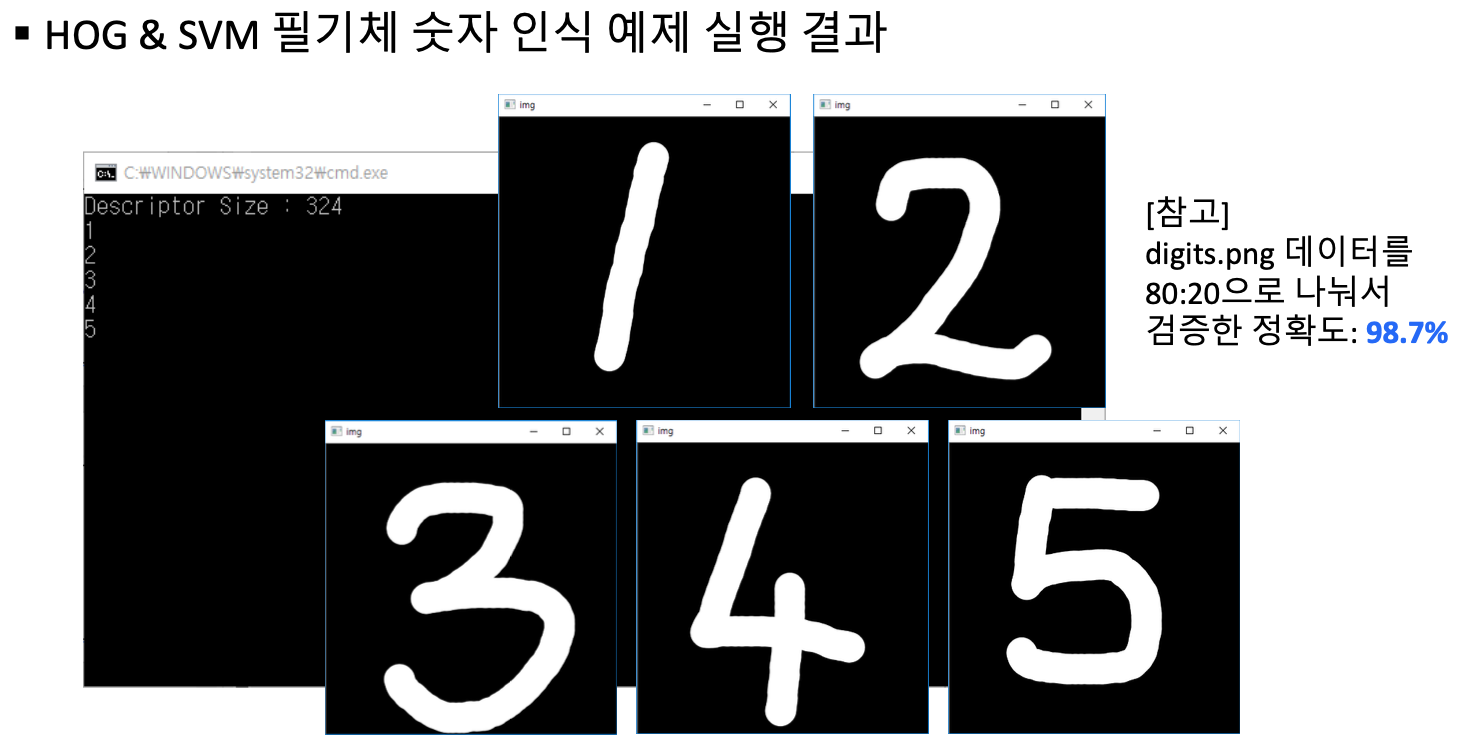

### 숫자 영상 정규화
학습 데이터 영상 정규화(Normalization)
- 위치, 크기, 회전 등의 요소를 정규화(인식 성능 향상)
- 숫자 영상의 무게 중심이 전체 영상 중앙이 되도록 위치 정규화

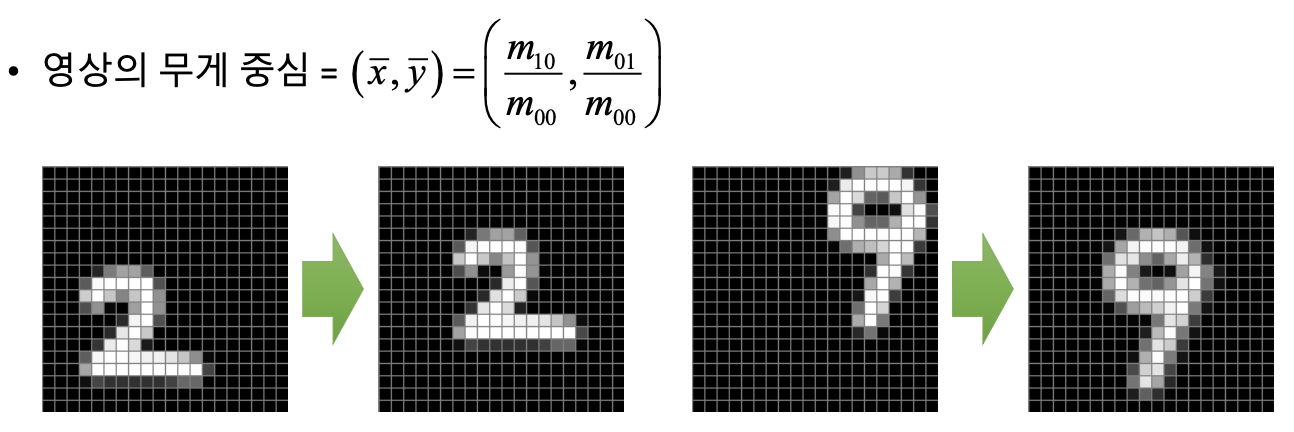

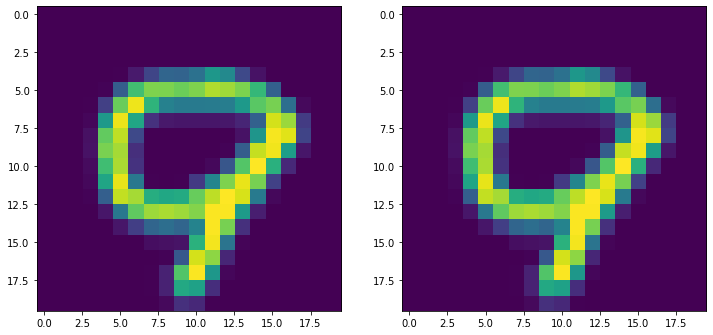

In [ ]:
def norm_digit(img):
  m = cv2.moments(img)
  cx = m['m10'] / m['m00']
  cy = m['m01'] / m['m00']
  h, w = img.shape[:2]
  aff = np.array([[1, 0, w/2 - cx], [0, 1, h/2 - cy]], dtype=np.float32) 
  dst = cv2.warpAffine(img, aff, (0, 0))
  return dst

desc = []
for img in cells:
  img = norm_digit(img) 
  desc.append(hog.compute(img))

test_image = cv2.resize(img, (20, 20), interpolation=cv2.INTER_AREA) 
test_image = norm_digit(test_image)
test_desc = hog.compute(test_image)

plt.figure(figsize=(12,8))
plt.subplot(121); plt.imshow(img)
plt.subplot(122); plt.imshow(test_image)
plt.show()

### 딥러닝 이해와 영상 인식
- 순전파(foward), 추론(inference)만 가능하며 학습은 지원하지 않음

<b>cv2.dnn.readNet(model, config=None, framework=None) -> retval</b>
- model: 훈련된 가중치를 저장하고 있는 이진 파일 이름
- framework: 명시적인 딥러닝 프레임워크 이름

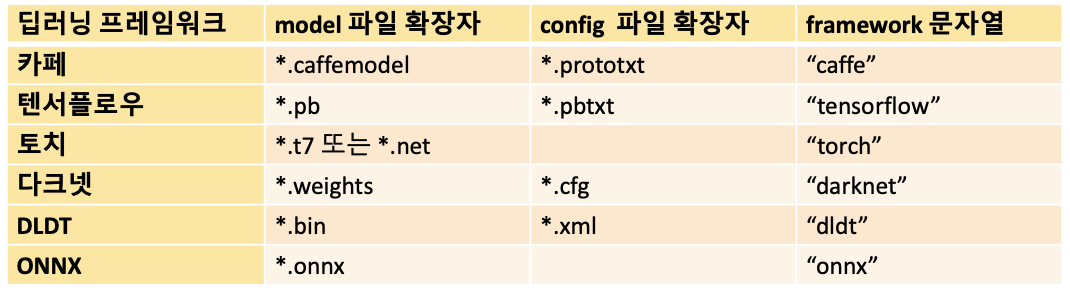

### 딥러닝 활용: 객체 검출
EAST: 문자 영역 검출(Scene text detection)

[Paper] https://arxiv.org/abs/1704.03155 <p>
[Code1] https://github.com/PaddlePaddle/PaddleOCR <p>
[Code2] https://github.com/argman/EAST <p>

- EAST는 이미지를 입력으로 받아 문자가 위치하는 bounding box 정보를 output으로 출력하는 모델(word box detection의 정확성을 높이는 기술에 초점)
- FCN(Fully Convolutional Network) 모델 구조를 사용하고 있음
- output(x, y, w, h, theta)은 score map과 함께 5개의 geometry 정보가 출력되는데, geometry 정보는 픽셀과 bounding box 4개 변 사이의 거리 정보, bounding box가 회전된 각도 

참고. FCN

- 이미지에 있는 물체가 어떤 클래스에 속하는지는 예측해낼 수 있지만, 그 물체가 어디에 존재하는지는 예측해낼 수 없음.
- 네트워크 후반부의 fully connected 층에 들어서면서 위치정보가 소실되었기 때문.


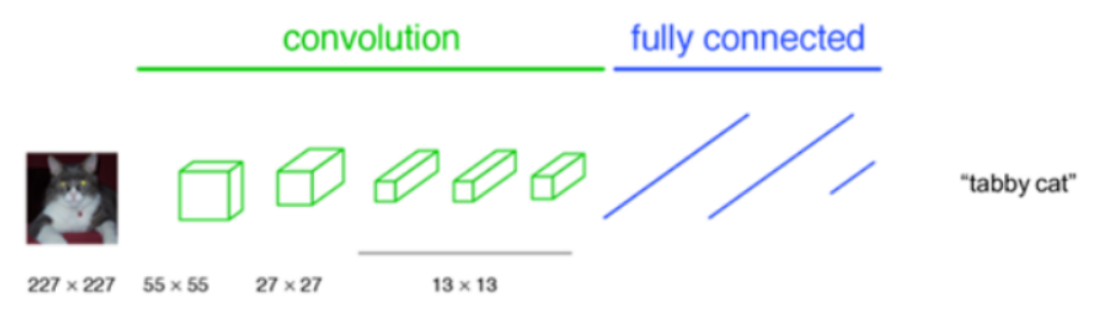

Fully Connected 층이 없어졌으므로 이제 더이상 입력 이미지의 크기에 제한을 받지 않게 됨(?)
- 고정된 크기의 인풋만을 허용하는 fully connected 층을 1x1 convolution layer 로 바꿈

Convolution Layer들을 거치고 나서 얻게 된 마지막 특성맵의 갯수는 훈련된 클래수의 갯수와 동일

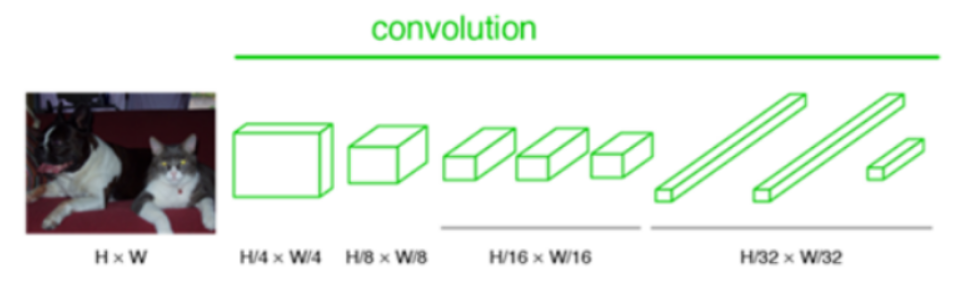

In [ ]:
import math

def decode(scores, geometry, scoreThreshold):
    detections = []
    confidences = []

    # geometry.shape=(1, 5, 80, 80)
    # scores.shape=(1, 1, 80, 80)

    height = scores.shape[2]
    width = scores.shape[3]

    for y in range(0, height):
        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]

        for x in range(0, width):
            score = scoresData[x]

            if(score < scoreThreshold):
                continue

            # feature map은 320x320 블롭의 1/4 크기이므로, 다시 4배 확대
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # (offsetX, offsetY) 위치에서 회전된 사각형 정보 추출
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # 회전된 사각형의 한쪽 모서리 점 좌표 계산
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x],
                       offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # 회전된 사각형의 대각선에 위치한 두 모서리 점 좌표 계산
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = ((p1[0]+p3[0])/2, (p1[1]+p3[1])/2)

            detections.append((center, (w, h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    return [detections, confidences]

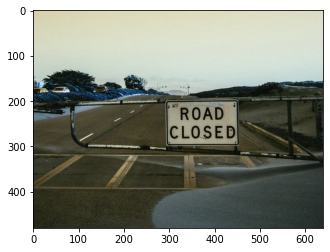

In [ ]:
#모델&설정 파일
model = gpath+'ch13/EAST/frozen_east_text_detection.pb' 
confThreshold = 0.5
nmsThreshold = 0.4

img = cv2.imread(gpath+'ch13/road_closed.jpg')
plt.imshow(img)
plt.show()

# 네트워크 생성
net = cv2.dnn.readNet(model)
# 블롭 생성&추론
blob = cv2.dnn.blobFromImage(img, 1, (320, 320), (123.68, 116.78, 103.94), True) 
net.setInput(blob)
# Score 정보, Text quadrangle 정보(RBox)
outs = net.forward(['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'])

# Get scores and geometry
scores = outs[0] # scores.shape=(1, 1, 80, 80) 
geometry = outs[1] # geometry.shape=(1, 5, 80, 80)

In [ ]:
# score가 confThreshold보다 큰 RBOX 정보를 RotatedRect 형식으로 변환하여 반환 
[boxes, confidences] = decode(scores, geometry, confThreshold)

# 회전된 사각형에 대한 비최대 억제
indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

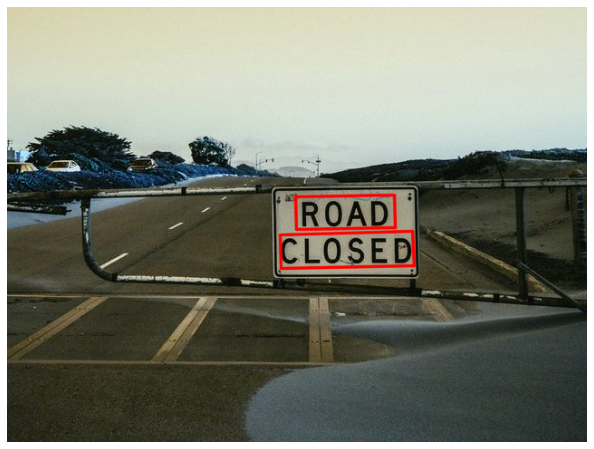

In [ ]:
rw = img.shape[1] / 320
rh = img.shape[0] / 320

for i in indices:
    # 회전된 사각형의 네 모서리 점 좌표 계산 & 표시
    vertices = cv2.boxPoints(boxes[i[0]])

    for j in range(4):
        vertices[j][0] *= rw
        vertices[j][1] *= rh

    for j in range(4):
        p1 = (vertices[j][0], vertices[j][1])
        p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
        cv2.line(img, p1, p2, (255, 0, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

끝.

### 참고사항

[Review] Text Detection and Recognition in the Wild: A Review
: https://neverabandon.tistory.com/m/60